# Training exploration (clean flow)
Two YOLO baselines (nano/small), consolidated results, and per-prediction analysis in one master DataFrame.


In [1]:
%matplotlib inline
from pathlib import Path
import sys
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO


# Normalize project root
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
from src.training import train_model, evaluate_model
from src.config import Paths, TrainingConfig
from src import data as data_utils

# Dataset (YOLO format). Swap root to try another dataset.
DATASET_ROOT = PROJECT_ROOT / "Poles2025/roadpoles_v1"
paths = Paths(dataset_root=DATASET_ROOT)

# Inference / matching controls
CONF_THRESH = 0.25
IOU_MATCH = 0.5
OVERLAP_IOU_THRESH = 0.3
MAX_EVAL_IMAGES = 400000
DATASET_ROOT


PosixPath('/home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/Poles2025/roadpoles_v1')

In [2]:
# Define experiments (light -> slightly heavier)
experiments = [
    # {"name": "yolov8n_baseline", "model": "yolov8n.pt", "epochs": 3, "batch": 8, "imgsz": 640},
    # {"name": "yolov8s_baseline", "model": "yolov8s.pt", "epochs": 3, "batch": 8, "imgsz": 640},
    # {"name": "yolo11n_baseline", "model": "yolo11n.pt", "epochs": 3, "batch": 8, "imgsz": 640},
    # {"name": "yolo11n_1280_baseline", "model": "yolo11n.pt", "epochs": 3, "batch": 8, "imgsz": 1280},
    {"name": "yolo11s_baseline", "model": "yolo11s.pt", "epochs": 3, "batch": 8, "imgsz": 640},
    {"name": "yolo11s_1280_baseline", "model": "yolo11s.pt", "epochs": 3, "batch": 8, "imgsz": 1280},
    # {"name": "yolo11m_1280_baseline", "model": "yolo11m.pt", "epochs": 3, "batch": 8, "imgsz": 1280},
]
experiments


[{'name': 'yolo11s_baseline',
  'model': 'yolo11s.pt',
  'epochs': 3,
  'batch': 8,
  'imgsz': 640},
 {'name': 'yolo11s_1280_baseline',
  'model': 'yolo11s.pt',
  'epochs': 3,
  'batch': 8,
  'imgsz': 1280}]

In [3]:
# Helper functions
def metrics_from_results(metrics_obj):
    res = getattr(metrics_obj, "results_dict", {}) or {}
    return {
        "precision": res.get("metrics/precision(B)"),
        "recall": res.get("metrics/recall(B)"),
        "map50": res.get("metrics/mAP50(B)"),
        "map5095": res.get("metrics/mAP50-95(B)"),
    }

def xywh_to_xyxy(xywh):
    cx, cy, w, h = xywh
    return np.array([cx - w/2, cy - h/2, cx + w/2, cy + h/2])

def iou(box1, box2):
    xa, ya = max(box1[0], box2[0]), max(box1[1], box2[1])
    xb, yb = min(box1[2], box2[2]), min(box1[3], box2[3])
    inter = max(0, xb - xa) * max(0, yb - ya)
    area1 = max(0, box1[2]-box1[0]) * max(0, box1[3]-box1[1])
    area2 = max(0, box2[2]-box2[0]) * max(0, box2[3]-box2[1])
    union = area1 + area2 - inter + 1e-9
    return inter / union


In [4]:
# Train and evaluate all experiments
results_rows = []
for exp in experiments:
    print(f"=== Training {exp['name']} ({exp['model']}) ===")
    cfg = TrainingConfig(
        model=exp["model"],
        epochs=exp["epochs"],
        batch=exp["batch"],
        imgsz=exp["imgsz"],
        patience=10,
    )
    train_res = train_model(paths=paths, cfg=cfg, overrides={"name": exp["name"]})
    best_weights = Path(train_res.save_dir) / "weights" / "best.pt"

    metrics = evaluate_model(weights=best_weights, paths=paths, imgsz=cfg.imgsz, batch=cfg.batch)
    m = metrics_from_results(metrics)

    results_rows.append({
        "name": exp["name"],
        "model": exp["model"],
        "train_time_s": getattr(train_res, "train_time_seconds", None),
        "eval_time_s": getattr(metrics, "eval_time_seconds", None),
        "save_dir": str(train_res.save_dir),
        "weights": str(best_weights),
        **m,
    })

results_df = pd.DataFrame(results_rows)
display(results_df.sort_values('map50', ascending=False))


=== Training yolo11s_baseline (yolo11s.pt) ===
New https://pypi.org/project/ultralytics/8.3.231 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.230 🚀 Python-3.13.5 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24208MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/Poles2025/roadpoles_v1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0,

,name,model,train_time_s,eval_time_s,save_dir,weights,precision,recall,map50,map5095
1,yolo11s_1280_baseline,yolo11s.pt,29.952037,2.748113,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.449761,0.831858,0.542661,0.290037
0,yolo11s_baseline,yolo11s.pt,22.115601,2.003203,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.698413,0.389381,0.518520,0.267335


## Aggregate metrics plots
Quick comparison of precision/recall/mAP and time.


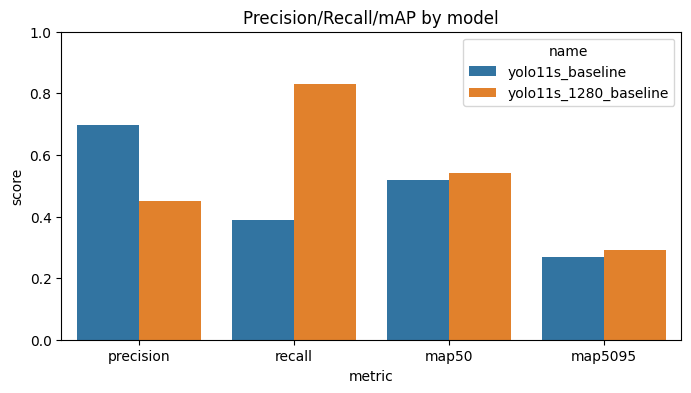

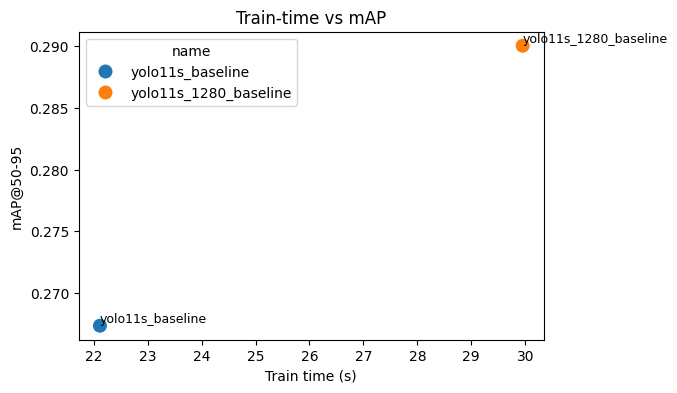

In [5]:
plot_df = results_df.melt(id_vars=['name','model'], value_vars=['precision','recall','map50','map5095'], var_name='metric', value_name='score')
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=plot_df, x='metric', y='score', hue='name', ax=ax)
ax.set_title('Precision/Recall/mAP by model')
ax.set_ylim(0, 1)
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=results_df, x='train_time_s', y='map5095', hue='name', s=120, ax=ax)
for _, row in results_df.iterrows():
    ax.text(row['train_time_s'], row['map5095'], row['name'], fontsize=9, ha='left', va='bottom')
ax.set_xlabel('Train time (s)')
ax.set_ylabel('mAP@50-95')
ax.set_title('Train-time vs mAP')
plt.show()


## Per-prediction analysis (single model)
Use the best mAP@50 model to score a subset of val images and build a single consolidated DataFrame of predictions, matches, and metrics.


In [6]:
# Select best model by mAP50
best_row = results_df.sort_values('map50', ascending=False).iloc[0]
weights_path = Path(best_row['weights'])
print(f'Using weights: {weights_path}')
model = YOLO(weights_path)

# Load val annotations
val_df = data_utils.load_annotations('valid', paths.dataset_root)
val_images = val_df['image_path'].dropna().unique().tolist()
print(f'Validation images: {len(val_images)}')
assert val_images, 'No validation images found'

sample_imgs = random.sample(val_images, k=min(MAX_EVAL_IMAGES, len(val_images)))
pred_results = model(sample_imgs, conf=CONF_THRESH, iou=OVERLAP_IOU_THRESH, verbose=False)
print(f'Ran inference on {len(sample_imgs)} images')


Using weights: /home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/notebooks/runs/yolo11s_1280_baseline3/weights/best.pt
Validation images: 92
Ran inference on 92 images


In [7]:
# Build per-prediction DataFrame with GT matching and attach run-level metrics
records = []
for img_path, pred in zip(sample_imgs, pred_results):
    gt_rows = val_df[val_df['image_path'] == Path(img_path)]
    gt_boxes = [xywh_to_xyxy((r.cx, r.cy, r.w, r.h)) for r in gt_rows.itertuples()]
    if pred.boxes is None:
        continue
    pred_xywhn = pred.boxes.xywhn.cpu().numpy()
    pred_conf = pred.boxes.conf.cpu().numpy()
    for idx, (xywh, conf) in enumerate(zip(pred_xywhn, pred_conf)):
        p_box = xywh_to_xyxy(xywh)
        best_iou = 0.0
        best_gt = -1
        for j, g in enumerate(gt_boxes):
            score = iou(p_box, g)
            if score > best_iou:
                best_iou = score; best_gt = j
        records.append({
            'model_name': best_row['name'],
            'image_path': Path(img_path),
            'pred_idx': idx,
            'conf': float(conf),
            'cx': float(xywh[0]), 'cy': float(xywh[1]), 'w': float(xywh[2]), 'h': float(xywh[3]),
            'best_iou': float(best_iou),
            'matched_gt': best_gt if best_iou >= IOU_MATCH else -1,
        })
pred_df = pd.DataFrame(records)
pred_df['hit'] = pred_df['matched_gt'] >= 0

# Attach run-level metrics (duplicated per prediction for convenience)
meta_cols = ['precision','recall','map50','map5095','train_time_s','eval_time_s','weights']
meta = best_row[meta_cols].to_dict()
for k, v in meta.items():
    pred_df[k] = v

display(pred_df.head())
print(f'Total predictions: {len(pred_df)}')


,model_name,image_path,pred_idx,conf,cx,cy,w,h,best_iou,matched_gt,hit,precision,recall,map50,map5095,train_time_s,eval_time_s,weights
0,yolo11s_1280_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0,0.469135,0.811750,0.641661,0.018380,0.255676,0.492760,-1,False,0.449761,0.831858,0.542661,0.290037,29.952037,2.748113,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...
1,yolo11s_1280_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0,0.272587,0.248089,0.594009,0.004901,0.078273,0.554826,0,True,0.449761,0.831858,0.542661,0.290037,29.952037,2.748113,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...
2,yolo11s_1280_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0,0.407324,0.591235,0.572875,0.004105,0.067018,0.743992,0,True,0.449761,0.831858,0.542661,0.290037,29.952037,2.748113,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...
3,yolo11s_1280_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0,0.446900,0.659973,0.616640,0.005803,0.118364,0.681032,1,True,0.449761,0.831858,0.542661,0.290037,29.952037,2.748113,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...
4,yolo11s_1280_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,1,0.281772,0.137074,0.594952,0.006822,0.084721,0.871740,0,True,0.449761,0.831858,0.542661,0.290037,29.952037,2.748113,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...


Total predictions: 107


### Aggregated prediction quality
Confidence and IoU distributions by hit/miss.


,hit,count,mean
0,False,21,0.398874
1,True,86,0.455931


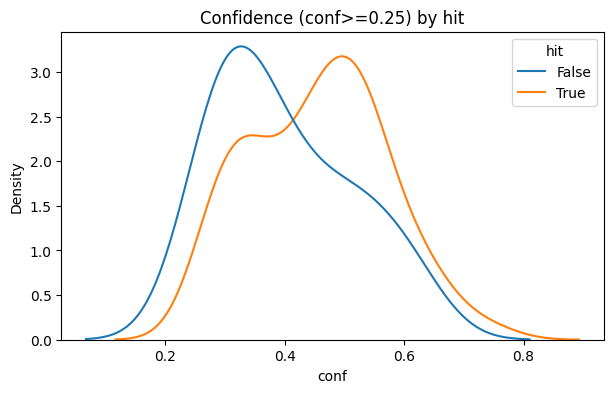

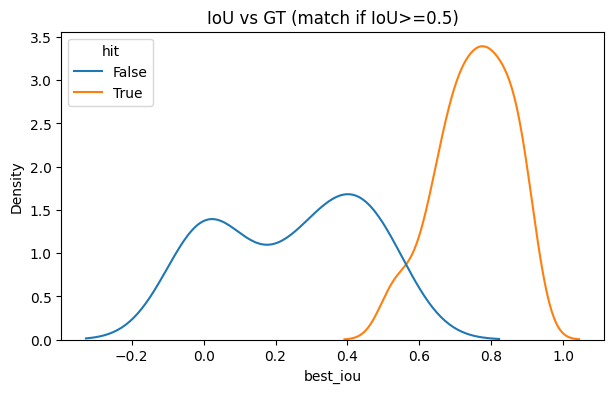

In [8]:
summary = pred_df.groupby('hit')['conf'].agg(['count','mean']).reset_index()
display(summary)

fig, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(data=pred_df, x='conf', hue='hit', common_norm=False, ax=ax)
ax.set_title(f'Confidence (conf>={CONF_THRESH}) by hit')
plt.show()

fig, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(data=pred_df, x='best_iou', hue='hit', common_norm=False, ax=ax)
ax.set_title(f'IoU vs GT (match if IoU>={IOU_MATCH})')
plt.show()


### Visualize one TP and one FP (confidence shaded)


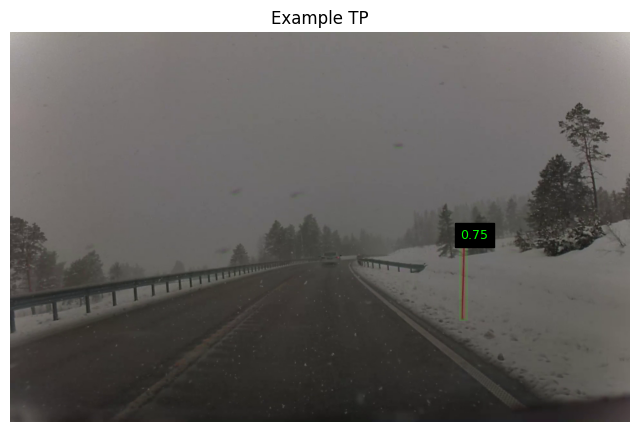

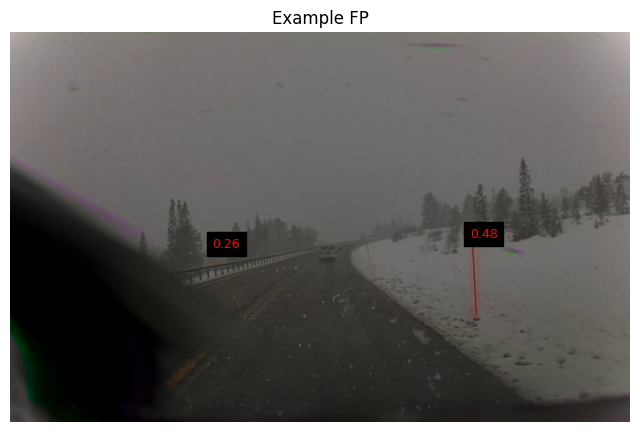

In [9]:
def visualize_prediction(img_path, pred, title, edgecolor='cyan'):
    img = plt.imread(img_path)
    h, w = img.shape[:2]
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(img)
    if pred.boxes is not None:
        xywhn = pred.boxes.xywhn.cpu().numpy()
        confs = pred.boxes.conf.cpu().numpy()
        for (cx, cy, bw, bh), c in zip(xywhn, confs):
            cx_px, cy_px = cx * w, cy * h
            bw_px, bh_px = bw * w, bh * h
            x0, y0 = cx_px - bw_px/2, cy_px - bh_px/2
            alpha = min(max(c, 0.1), 1.0)
            rect = plt.Rectangle((x0, y0), bw_px, bh_px, linewidth=2, edgecolor=edgecolor, facecolor='red', alpha=0.15*alpha)
            ax.add_patch(rect)
            ax.text(x0, y0-2, f'{c:.2f}', color=edgecolor, fontsize=9, backgroundcolor='black')
    ax.set_title(title)
    ax.axis('off')
    plt.show()

# Pick best TP and best FP by confidence
tp_row = pred_df[pred_df['hit']].sort_values('conf', ascending=False).head(1)
fp_row = pred_df[~pred_df['hit']].sort_values('best_iou', ascending=True).head(1)

def _get_pred_for_image(path_str):
    if path_str in sample_imgs:
        return pred_results[sample_imgs.index(path_str)]
    return None

if not tp_row.empty:
    img_path = tp_row.iloc[0]['image_path']
    pred = _get_pred_for_image(img_path)
    if pred is not None:
        visualize_prediction(img_path, pred, title='Example TP', edgecolor='lime')

if not fp_row.empty:
    img_path = fp_row.iloc[0]['image_path']
    pred = _get_pred_for_image(img_path)
    if pred is not None:
        visualize_prediction(img_path, pred, title='Example FP', edgecolor='red')


In [10]:
fp_row

,model_name,image_path,pred_idx,conf,cx,cy,w,h,best_iou,matched_gt,hit,precision,recall,map50,map5095,train_time_s,eval_time_s,weights
34,yolo11s_1280_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,1,0.260172,0.32914,0.574936,0.005293,0.043012,0.0,-1,False,0.449761,0.831858,0.542661,0.290037,29.952037,2.748113,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...


### Notes
- `pred_df` is the consolidated "everything" table: predictions + confidence + IoU match + run metrics.
- Adjust `CONF_THRESH`, `IOU_MATCH`, and `MAX_EVAL_IMAGES` up top for stricter/looser analysis.
- For reproducibility, set seeds on sampling/training if needed.


### Error characterization (hits vs misses)
Quantitative and qualitative signals to understand what distinguishes correct vs wrong predictions.


In [11]:
import cv2

assert 'pred_df' in globals(), 'Run the prediction analysis cells first to populate pred_df'

def compute_image_stats_for_preds(df):
    rows = []
    seen = {}
    for img_path in df['image_path'].dropna().unique():
        if img_path in seen:
            continue
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        rows.append({
            'image_path': img_path,
            'brightness': float(gray.mean()),
            'contrast': float(gray.std()),
            'blur': float(cv2.Laplacian(gray, cv2.CV_64F).var()),
        })
        seen[img_path] = True
    return pd.DataFrame(rows)

img_stats = compute_image_stats_for_preds(pred_df)
pred_df_ext = pred_df.copy()
pred_df_ext['box_area'] = pred_df_ext['w'] * pred_df_ext['h']
pred_df_ext['aspect'] = pred_df_ext['w'] / (pred_df_ext['h'] + 1e-9)
pred_df_ext = pred_df_ext.merge(img_stats, on='image_path', how='left')
display(pred_df_ext.head())


,model_name,image_path,pred_idx,conf,cx,cy,w,h,best_iou,matched_gt,...,map50,map5095,train_time_s,eval_time_s,weights,box_area,aspect,brightness,contrast,blur
0,yolo11s_1280_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0,0.469135,0.811750,0.641661,0.018380,0.255676,0.492760,-1,...,0.542661,0.290037,29.952037,2.748113,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.004699,0.071888,89.491939,29.989089,7.681754
1,yolo11s_1280_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0,0.272587,0.248089,0.594009,0.004901,0.078273,0.554826,0,...,0.542661,0.290037,29.952037,2.748113,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.000384,0.062619,98.544206,38.550399,30.570245
2,yolo11s_1280_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0,0.407324,0.591235,0.572875,0.004105,0.067018,0.743992,0,...,0.542661,0.290037,29.952037,2.748113,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.000275,0.061255,90.358860,29.558734,7.413829
3,yolo11s_1280_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0,0.446900,0.659973,0.616640,0.005803,0.118364,0.681032,1,...,0.542661,0.290037,29.952037,2.748113,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.000687,0.049023,90.510691,31.934140,8.866901
4,yolo11s_1280_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,1,0.281772,0.137074,0.594952,0.006822,0.084721,0.871740,0,...,0.542661,0.290037,29.952037,2.748113,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.000578,0.080522,90.510691,31.934140,8.866901


#### Summary stats by hit/miss


In [12]:
summary = pred_df_ext.groupby('hit')[['conf','best_iou','box_area','aspect','brightness','contrast','blur']].agg(['mean','median'])
summary


conf            best_iou            box_area              aspect  \
           mean    median      mean    median      mean    median      mean   
hit                                                                           
False  0.398874  0.373822  0.243815  0.300867  0.003435  0.001607  0.084008   
True   0.455931  0.470108  0.753173  0.761679  0.001112  0.000645  0.078903   

                brightness              contrast                  blur  \
         median       mean     median       mean     median       mean   
hit                                                                      
False  0.076933  90.853091  90.215535  32.571828  31.269170  13.691995   
True   0.074506  92.318994  90.848284  34.204677  32.374148  15.752017   

                 
         median  
hit              
False  8.784587  
True   9.547839

#### Distributions


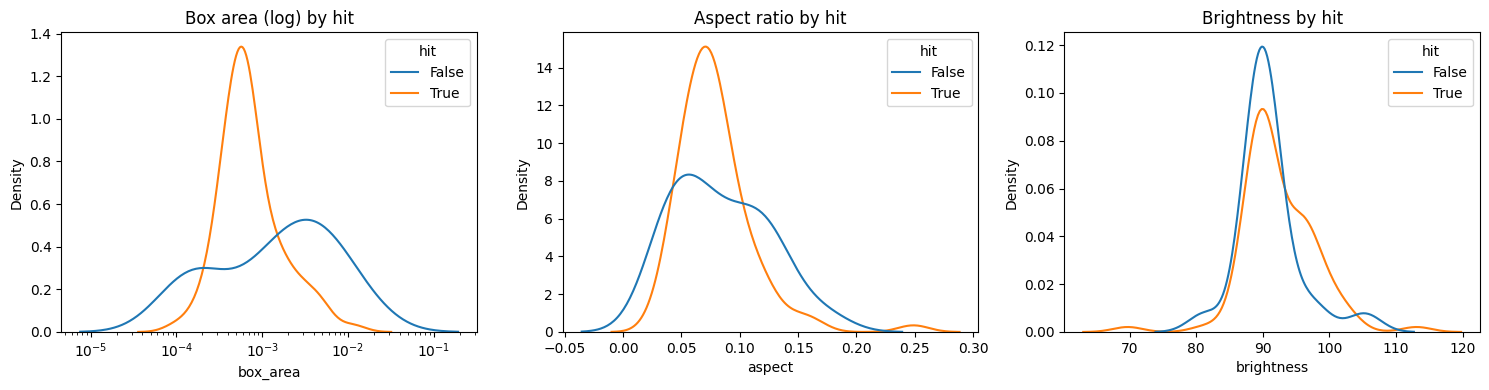

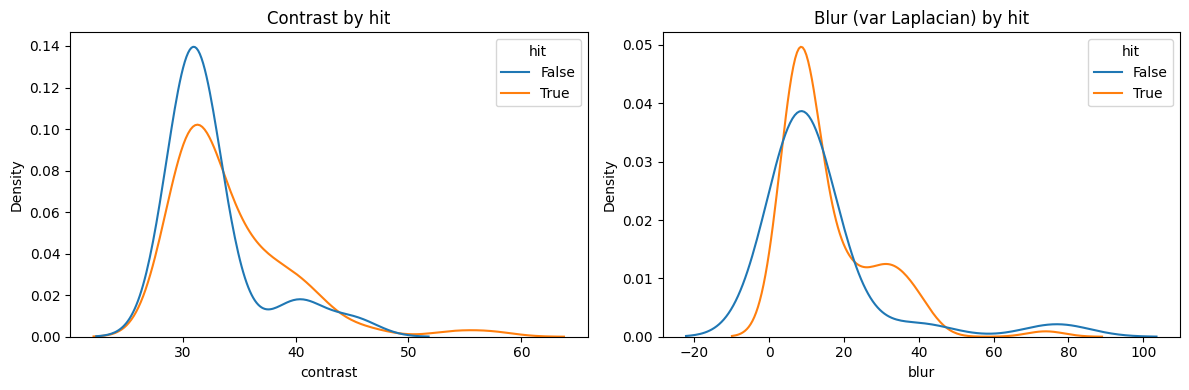

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.kdeplot(data=pred_df_ext, x='box_area', hue='hit', common_norm=False, ax=axes[0], log_scale=True)
axes[0].set_title('Box area (log) by hit')
sns.kdeplot(data=pred_df_ext, x='aspect', hue='hit', common_norm=False, ax=axes[1])
axes[1].set_title('Aspect ratio by hit')
sns.kdeplot(data=pred_df_ext, x='brightness', hue='hit', common_norm=False, ax=axes[2])
axes[2].set_title('Brightness by hit')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.kdeplot(data=pred_df_ext, x='contrast', hue='hit', common_norm=False, ax=axes[0])
axes[0].set_title('Contrast by hit')
sns.kdeplot(data=pred_df_ext, x='blur', hue='hit', common_norm=False, ax=axes[1])
axes[1].set_title('Blur (var Laplacian) by hit')
plt.tight_layout()
plt.show()


#### Hardest cases to inspect
List a few top false positives and low-IoU hits for qualitative review.


In [14]:
hard_fp = pred_df_ext[~pred_df_ext['hit']].sort_values(['conf','best_iou'], ascending=[False, True]).head(5) if len(pred_df_ext[~pred_df_ext['hit']]) else pd.DataFrame()
hard_tp = pred_df_ext[pred_df_ext['hit']].sort_values('best_iou').head(5) if len(pred_df_ext[pred_df_ext['hit']]) else pd.DataFrame()
print('Top false positives (by conf):')
display(hard_fp[['image_path','conf','best_iou','brightness','contrast','blur']])
print('Lowest-IoU true positives:')
display(hard_tp[['image_path','conf','best_iou','brightness','contrast','blur']])


Top false positives (by conf):


,image_path,conf,best_iou,brightness,contrast,blur
91,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.624207,0.351592,90.858868,31.269170,10.541996
92,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.596943,0.429687,90.858868,31.269170,10.541996
89,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.555549,0.480965,98.201031,40.302283,40.462156
36,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.539169,0.000000,90.993549,31.584914,8.844827
93,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.495685,0.111058,90.858868,31.269170,10.541996


Lowest-IoU true positives:


,image_path,conf,best_iou,brightness,contrast,blur
30,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.312100,0.516920,88.816140,29.437723,6.806075
60,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.585384,0.519515,89.867386,53.858975,13.840344
70,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.383782,0.519945,90.215535,30.869638,8.784587
20,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.607747,0.544096,97.475363,36.297583,27.905257
1,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.272587,0.554826,98.544206,38.550399,30.570245


### Takeaways
- Use the summaries to see if misses cluster in low brightness/high blur or tiny box area.
- Inspect `hard_fp`/`hard_tp` image paths to understand visual patterns (e.g., snow glare, poles near edge).
- Adjust confidence/NMS or augmentations based on observed failure modes.
